In [24]:
import os
import re

def env_vars():
    with open('.env', 'r') as f:
        lines = f.readlines()
    
    lines = [re.sub('"|\n', '', x) for x in lines]
    lines = [{x.split('=')[0]: x.split('=')[1]} for x in lines]

    env_object = {}
    for json_ in lines:
        for key, value in json_.items():
            env_object[key] = value

    return env_object

ENV_VARS = env_vars()
OPEN_AI_KEY=ENV_VARS['OPEN_AI_KEY']
RAPID_API_KEY=ENV_VARS['RAPID_API_KEY']
HUGGINGFACEHUB_API_TOKEN=ENV_VARS['HUGGINGFACEHUB_API_TOKEN']

# OPEN_AI_KEY = os.getenv('OPEN_AI_KEY', default='')
os.environ['OPENAI_API_KEY'] = OPEN_AI_KEY

os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN


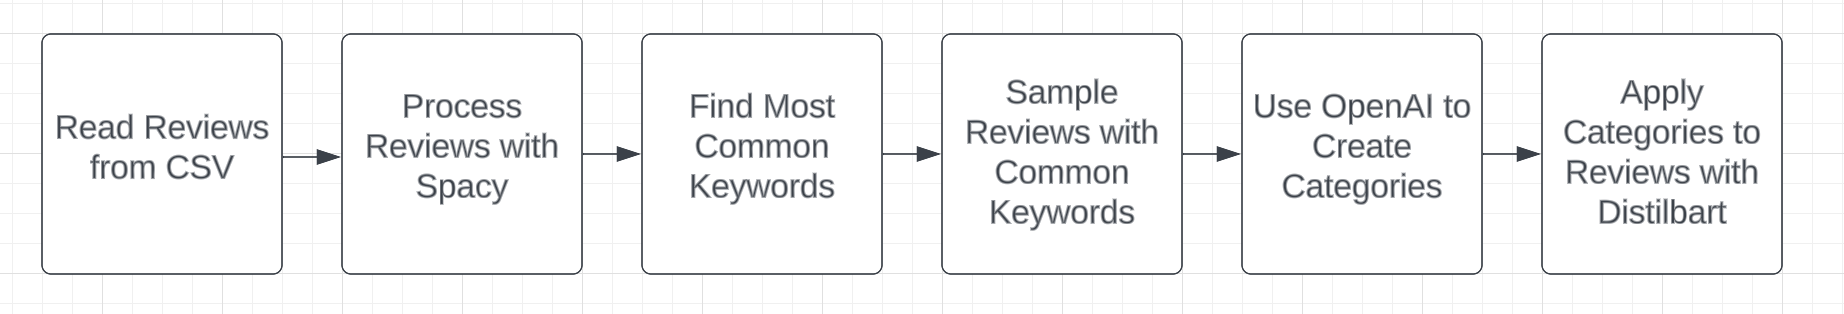

<b>Data Sources</b>

I sourced these Amazon reviews from Rapid API, which has lots of API for all sorts of things like Google Maps data, Yelp data, news data, social media data, and all sorts of data that you could scrape.

The GDELT Project is an initiative to construct a catalog of human societal-scale behavior and beliefs across all countries of the world. It's basically a giant database of political events that is updated every 15 minutes with links to news articles. I've been thinking about applying these machine learning ideas to news data, and this might be an interesting project for anyone who wants to dive into machine learning.

https://rapidapi.com/
<br>
https://www.gdeltproject.org/

<img src="./markdown/pipeline_part_1.png"/>

In [30]:
#~Read Reviews from CSV
import pandas as pd
from datetime import datetime
reviews_df = pd.read_csv('boxing_glove_reviews.csv', sep='|')

reviews_df

,USER,REVIEW_ID,ASIN_ORIGINAL_ID,ASIN_VARIANT_ID,REVIEWER_NAME,RATING,REVIEW_DATE,REVIEW_DATE_UNIX,TITLE,REVIEW,VERIFIED_PURCHASE,LOAD_DATE
0,user,R2DWO7PFQC2XJD,B07L38V2X1,B081G4RG7T,AJ,5,"May 21, 2023",1684634400,Boxing gloves,Very comfortable for my son . Right fit .,True,2023-05-25 20:31:25.712810
1,user,R3O97UZJ9WHI6W,B07L38V2X1,B07L38V2X1,William scruton,5,"May 17, 2023",1684288800,Perfect,Great glove feels amazing the size is a bit sm...,True,2023-05-25 20:31:25.712820
2,user,R383VCHU35WJCW,B07L38V2X1,B07L38V2X1,Ronald,1,"May 12, 2023",1683856800,Disappointed.!,I bought a pair of the purple Hayabusa 16 oz g...,False,2023-05-25 20:31:25.712822
3,user,R1O85E9KIZSIZ0,B07L38V2X1,B07L374S9J,PLCHU,5,"May 11, 2023",1683770400,Boxing,Great wrist support and alot of foam to protec...,True,2023-05-25 20:31:25.712825
4,user,R2XUHG01QM87QT,B07L38V2X1,B081FKZ7QZ,Karolina T.,5,"May 6, 2023",1683338400,Love them!,"I love these! The look, the feel and they dry ...",True,2023-05-25 20:31:25.712828
...,...,...,...,...,...,...,...,...,...,...,...,...
9907,user,R2A89GSOPC7MG5,B079G45ZHH,NaN,Nicholas Johnson,5,"July 20, 2019",1563588000,Solid gloves,"I use them for kick boxing, I’m happy with them",True,2023-05-25 20:31:25.737679
9908,user,R3QEEY4TU4COI8,B079G45ZHH,NaN,Matthew Loertscher,5,"March 18, 2019",1552874400,Solid,Solid,True,2023-05-25 20:31:25.737681
9909,user,R1HTTP8GX1WIYF,B079G45ZHH,NaN,Felix Olvera,5,"December 20, 2018",1545271200,Great deal highly recommend,Real nice and comfortable worththe money.,True,2023-05-25 20:31:25.737683
9910,user,RGUOX71P0NY14,B079G45ZHH,NaN,Trey5seven,3,"November 28, 2018",1543370400,Ok cheap gloves will last 2-6 months,Great for bag work. These gloves have great kn...,True,2023-05-25 20:31:25.737686


<img src="./markdown/pipeline_part_2.png"/>

<b>Natural Language Processing</b> - https://www.ibm.com/topics/natural-language-processing

The field of artificial intelligence concerned with giving computers the ability to understand text and spoken words in much the same way human beings can.

<ul>
    <li>Speech recognition</li>
    <li>Part of speech tagging - nouns, verbs, etc</li>
    <li>Named entity recognition - locations, people's names</li>
    <li>Sentiment analysis - postive, negative, angry, sad, etc</li>
    <li>Text Summarization</li>
</ul>



---

<b>Spacy</b> - https://spacy.io/

spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python.

spaCy is designed specifically for production use and helps you build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.






<b>Using NLP to Process Reviews</b>

Using machine learning tools requires balancing output quality, performance speed, and cost. I use OpenAI's Davinci 3 model later in this project, which costs around 2 cents per 1000 tokens, including both input and output. Per OpenAI, their average token is around 4 characters.

So if you send a 400 character instruction to OpenAI and it gives you a 200 character response, you will be charged for about 150 tokens ((400+200)/4), or around 0.3 cents. While that number seems small, it adds up if you run this for millions of reviews.

I use Spacy to remove stop words and lemmatize words. Stop words are words like and, or, & the that carry little meaning by themselves. Lemmatize refers to distilling similar words down to a base word, for example, reducing "builds", "building", or "built" to the lemma "build".


<img src="./markdown/lemmatization.png" width="300" height="300" />
<img src="./markdown/stopwords.png" width="300" height="300" />
<img src="./markdown/tokenization.png" width="300" height="300" />

In [16]:
#~Lemmatize reviews and remove stopwords
import spacy
import re
 
 #there are different sized models for different use cases
spacy_nlp = spacy.load("en_core_web_md")

#Stop words - words that are removed before text processing because they are insignificant
#Examples - the, is, and
def remove_stops(doc):
    # Filter out stop words by using the `token.is_stop` attribute
    return [token.text for token in doc if not token.is_stop]

# the process of reducing the different forms of a word to one single base form
# for example, reducing "builds", "building", or "built" to the lemma "build": 
def lemmatize(doc):
    # Take the `token.lemma_` of each non-stop word
    return [token.lemma_ for token in doc if not token.is_stop]

# titles = reviews_df['TITLE'].astype(str).to_list()
reviews = reviews_df['REVIEW'].astype(str).to_list()

lemmatized_reviews = [re.sub(r'[^\w\s]', '', str(x)) for x in reviews]
lemmatized_reviews = [lemmatize(spacy_nlp(x)) for x in lemmatized_reviews]
lemmatized_reviews = [' '.join(x) for x in lemmatized_reviews]

In [17]:
lemmatized_reviews

['comfortable son   right fit',
 'great glove feel amazing size bit small big hand big glove stretch fast easy',
 'buy pair purple Hayabusa 16 oz glove rarely use look yould look brand new take close look notice vinyl glove tear place disappointing',
 'great wrist support alot foam protect knuckle',
 'love look feel dry fast breathable mesh inside recommend beginner',
 'buy 2 pair bag work sparringgreat glove tight loosen useFeels light 16 oz maybe compactwill purchase',
 'excellent glove',
 'new boxing glove base review reputation purchase small size happy far take 5 class not heavy protect handsfinger',
 'comfortable pad',
 'stiff break inthey look feel',
 'like baseball softball mitt break work great',
 'buy recently start box perfect beginner wrist support great hand remain protect cute multiple color choose highly recommend',
 'start positive sweat wicke material cool touch love variety color choose con padding insufficient alright starter glove boxing padwork bagwork personally f

<img src="./markdown/pipeline_part_3.png"/>

In [18]:
#~Find most common words with spacy
from collections import Counter

# 'NOUN', 'ADJ', 'VERB'
def find_types_of_words(text, word_type_list, nlp=spacy_nlp):
    doc = nlp(text)
    words = [x.text.lower() for x in doc if x.pos_ in word_type_list]
    words = list(set(words))
    words.sort()
    ignore_words = ['have']
    words = [x for x in words if x not in ignore_words]
    
    return words

def most_common_words(text_list, word_type_list):
    all_review_adjectives = []
    for review in text_list:
        adjs = find_types_of_words(review, word_type_list)
        all_review_adjectives.extend(adjs)
    most_common_words = Counter(all_review_adjectives).most_common(500)
    return most_common_words

# title_top_nouns_adjs_verbs = most_common_words(titles, ['NOUN', 'ADJ', 'VERB'])
review_top_nouns_adjs_verbs = most_common_words(lemmatized_reviews, ['NOUN', 'ADJ', 'VERB'])

In [19]:
review_top_nouns_adjs_verbs

[('glove', 4681),
 ('great', 2410),
 ('good', 2315),
 ('hand', 1616),
 ('fit', 1498),
 ('bag', 1419),
 ('feel', 1314),
 ('quality', 1264),
 ('love', 1230),
 ('use', 1207),
 ('comfortable', 1198),
 ('wrist', 1107),
 ('buy', 1096),
 ('look', 1018),
 ('boxing', 962),
 ('work', 885),
 ('pair', 877),
 ('heavy', 852),
 ('price', 839),
 ('time', 796),
 ('padding', 743),
 ('recommend', 739),
 ('get', 709),
 ('nice', 692),
 ('support', 655),
 ('oz', 653),
 ('product', 618),
 ('wrap', 616),
 ('month', 601),
 ('week', 587),
 ('m', 568),
 ('hit', 542),
 ('perfect', 523),
 ('spar', 523),
 ('wear', 519),
 ('little', 516),
 ('year', 500),
 ('small', 499),
 ('start', 479),
 ('punch', 459),
 ('come', 455),
 ('knuckle', 449),
 ('hold', 435),
 ('purchase', 431),
 ('break', 420),
 ('training', 418),
 ('size', 411),
 ('go', 408),
 ('durable', 389),
 ('finger', 385),
 ('need', 383),
 ('beginner', 364),
 ('protection', 352),
 ('material', 349),
 ('big', 337),
 ('class', 337),
 ('son', 333),
 ('want', 330),
 

<img src="./markdown/pipeline_part_4.png"/>

In [21]:
#~Sample reviews so each common keyword is represented adequately
# The goal is to create categories for reviews based on the most commonly used keywords
import re

review_top_nouns_adjs_verbs_top_twenty = review_top_nouns_adjs_verbs[0:20]
review_top_nouns_adjs_verbs_vals = [x[0] for x in review_top_nouns_adjs_verbs_top_twenty]
review_top_nouns_adjs_verbs_regex = '(?:' + '|'.join(review_top_nouns_adjs_verbs_vals) + ')'
phrase_around_top_nouns_adjs_verbs_regex = '[ 0-9a-zA-Z]{1,50} ' + review_top_nouns_adjs_verbs_regex + '[ 0-9a-zA-Z]{1,50}[ \\.]{1}'

def phrase_around_top_words(review, regex):
    try:
        return re.findall(regex, review)
    except:
        return ['']

# review_top_nouns_adjs_verbs
starttime = datetime.now()
_phrases_around_keywords = []
for x in lemmatized_reviews[0:1500]:
    _phrases_around_keywords.extend(phrase_around_top_words(x, phrase_around_top_nouns_adjs_verbs_regex))

phrases_around_keywords = []
for x in _phrases_around_keywords[0:1500]:
    temp = {
        'keyword': re.findall(review_top_nouns_adjs_verbs_regex, x)[0],
        'phrase': x
    }
    phrases_around_keywords.append(temp)

phrases_around_keywords_df = pd.DataFrame(phrases_around_keywords)

print('Total time to finish:\t', str(datetime.now() - starttime))
# phrases_around_keywords_df

_sampled_phrases = phrases_around_keywords_df.groupby('keyword').head(8)['phrase'].to_list()
sampled_phrases = []

counter = 0
for x in _sampled_phrases:
    counter += 1
    sampled_phrases.append(str(counter) + ') ' + x)

sum([len(x) for x in sampled_phrases])
# for x in sampled_phrases[0:20]:
#     print(x)
#     print('')


Total time to finish:	 0:00:00.016526


13019

<img src="./markdown/pipeline_part_5.png"/>

<b>LangChain & Hugging Face</b>

LangChain & Hugging Face do most of the hard work by providing abstractions that distill complex machine learning code into a few lines of easy to read Python code.

In [26]:
#~Use GPT to generate labels

from langchain.llms import OpenAI
from langchain import PromptTemplate, LLMChain

create_topics_template = """
    Question: Please create 10 features that describe mostly frequently mentioned qualities of the product from the reviews below. Please output the categories as a numbered list separated by newline characters Reviews: {reviews}
    
    Answer: Here are 10 features:
"""
openai_llm = OpenAI(verbose=True, temperature=.1, model_name="text-davinci-003")
simple_prompt = PromptTemplate(input_variables=["reviews"], template=create_topics_template)
# openai_llm = ChatOpenAI(verbose=True, temperature=.1, model_name="gpt-3.5-turbo")
chain = LLMChain(llm=openai_llm, prompt=simple_prompt)
_features = chain.run(' '.join(sampled_phrases))
features = _features.split('\n')
features = [re.sub('[0-9]{1,2}\\. ', '', x) for x in features]


In [27]:
features

['Comfort',
 'Durability',
 'Fit',
 'Quality',
 'Padding',
 'Wrist support',
 'Breathability',
 'Price',
 'Sweat absorption',
 'Design']

<img src="./markdown/pipeline_part_6.png"/>

In [28]:
#~Assign labels with BERT zero shot learning classification
from transformers import pipeline

# classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
# classifier = pipeline("zero-shot-classification", model='cross-encoder/nli-deberta-base')
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-1")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Do not waste your money on these gloves. My hands would barely fit in them without wraps. They still would not close completely at the wrist. You cannot wear these with wraps.I thought they sent me kid's gloves.After 15 minutes I had to leave the because gym because I was so miserable.I had heard these were great gloves but not in my opinion. I have been training for 3 years with a bag. None of the guys could believe how poorly they fit.


In [29]:
total_start_time = datetime.now()
for rev in reviews[0:20]:
    incremental_start_time = datetime.now()
    x = classifier(rev, candidate_labels=features)['labels'][0]
    print('---------')
    print('time spent categorizing review:\t', str(datetime.now() - incremental_start_time))
    print(rev)
    print(x)
    


print('time for total:\t', str(datetime.now() - total_start_time))

time for increment:	 0:00:00.666369
Comfort
Very comfortable for my son . Right fit .
time for increment:	 0:00:00.628169
Quality
Great glove feels amazing the size is a bit small if you have a bigger hand even if you get bigger gloves but they stretch fast so you can get them on easier
time for increment:	 0:00:00.736429
Durability
I bought a pair of the purple Hayabusa 16 oz gloves.. I rarely use them, and if you looked at them you’ld say they look brand new.. however if you took a closer look at them you would notice that the vinyl on one of the gloves is tearing in two places.. very disappointing.!
time for increment:	 0:00:00.620801
Quality
Great wrist support and alot of foam to protect knuckles
time for increment:	 0:00:00.555791
Quality
I love these! The look, the feel and they dry up fast with the breathable mesh inside! I recommend them and not only for beginners!
time for increment:	 0:00:00.677476
Quality
Bought 2 pair one for Bag work and one for Sparring.Great gloves. Tig

In [4]:
# total_start_time = datetime.now()
# x_revs = reviews[0:10]
# x = classifier(x_revs, candidate_labels=features[0:10])#['labels'][0]

# print('time for total:\t', str(datetime.now() - total_start_time))

for feature in features:
    print(feature)

NameError: name 'features' is not defined

In [91]:
sample_reviews_df = reviews_df.head(500)
sample_reviews_df['TOPIC'] = sample_reviews_df.apply(lambda x: classifier(str(x['REVIEW']), candidate_labels=features)['labels'][0], axis=1)

/var/folders/6n/f_55qdsj5n5_t8r01jswj_680000gn/T/ipykernel_3529/2515589427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_reviews_df['TOPIC'] = sample_reviews_df.apply(lambda x: classifier(str(x['REVIEW']), candidate_labels=features)['labels'][0], axis=1)


In [12]:
word_list = list(set([x[0] for x in review_top_nouns_adjs_verbs]))
word_list.sort()
word_list = ', '.join(word_list)
word_list

prompt = """
    I am going to give you a list of words. Please tell me which refer to people ("who"), which refer to dates or times ("when"), which refer to places ("where"), and which describe actions or activities ("activities"). Please return your response as a JSON object with who, when, where, and what as keys, and the results as lists for values. If a word does not fit into one of those categories, you can exclude it from the response. Please exclude adjectives from your response. Words: 
"""

In [27]:
start = datetime.now()

print('Start time:\t', start)
######
total_start_time = datetime.now()
for rev in reviews[0:20]:
    incremental_start_time = datetime.now()
    x = classifier(rev, candidate_labels=features)['labels'][0]
    print('time for increment:\t', str(datetime.now() - incremental_start_time))
    print(x)
######

end = datetime.now()
print('Prediction time:', str(end-start))

Start time:	 2023-06-09 14:37:24.437837
time for increment:	 0:00:01.944262
Comfort
time for increment:	 0:00:02.223745
Quality
time for increment:	 0:00:03.800625
Durability
time for increment:	 0:00:01.448201
Quality
time for increment:	 0:00:02.084031
Quality
time for increment:	 0:00:02.699021
Quality
time for increment:	 0:00:01.240405
Quality
time for increment:	 0:00:03.208562
Quality
time for increment:	 0:00:01.233541
Fit
time for increment:	 0:00:01.774540
Quality
time for increment:	 0:00:01.800231
Quality
time for increment:	 0:00:02.517664
Quality
time for increment:	 0:00:05.625226
Quality
time for increment:	 0:00:03.717548
Quality
time for increment:	 0:00:01.802112
Wrist support
time for increment:	 0:00:02.455873
Quality
time for increment:	 0:00:02.449256
Quality
time for increment:	 0:00:11.142389
Fit
time for increment:	 0:00:01.914783
Price
time for increment:	 0:00:02.053763
Fit
Prediction time: 0:00:57.140367


In [36]:
###Hugging Face API

import requests
from datetime import datetime

def query(payload, model_id):
    start_time = datetime.now()
    headers = {"Authorization": f"Bearer {HUGGINGFACEHUB_API_TOKEN}"}
    API_URL = f"https://api-inference.huggingface.co/models/{model_id}"
    response = requests.post(API_URL, headers=headers, json=payload)
    print(str(datetime.now() - start_time))
    return response.json()

In [37]:
sample_review_1 = """
    Referencing the ILIFE V80 Max Mopping Robot Vacuum and Mop Combo.
    This vacuum was fairly easy to set up on the app (I’m a grandma, so it wasn’t a snap, but I eventually got it done and connected to Alexa)

    Once the vacuum was charged, I told Alexa to start Beastie (Yes, from the movie Malificent)
    Beastie started off on a journey throughout the house, then returned to the home base to charge. I’m embarrassed to say the dust bin was completely full. I repeated this process, after charging was complete, three times. Eventually, there was no more dog hair in the dust bin. All the floors were clean. EVEN UNDER THE BEDS!

    I live alone with my dog, so my house is very quiet. It did seem a little noisy but definitely not as noisy as a normal vacuum sweeper.

    I also used the mopping feature. It was much like my steamer without the steam. I sprayed the floor with fresh smelling cleaner (Mr. Clean) and then placed Beastie down to do a spot clean in the kitchen. It did a great job. There is zero noise when it’s mopping.. that was nice.

    My dog sheds A LOT. I had to dust mop the main kitchen/living room area and all rooms on the weekends. With this vacuum, I toss the dog toys onto a throw rug that is super plush and set it aside. The vacuum went over all the rest of the throw rugs in the bathrooms and office with no issues at all. It took about an hour for this vacuum to clean my whole house… a task that takes me several hours with the dust mop.

    I run this vacuum every morning. I get almost giddy when I walk through the house now and see and feel how clean my floors are!

    My only worry is what to do with my spare time now that I don’t have to dust mop… this was definitely a game changer!
"""

topics = ['Price', 'Quietness', 'Mopping']

payload = {
    "inputs": sample_review_1,
    "parameters": {
        "candidate_labels": topics,
        "task": "zero-shot-classification"
    }
}

model_id = 'valhalla/distilbart-mnli-12-1'
response = query(payload, model_id)
response

0:00:02.068919


{'sequence': '\n    Referencing the ILIFE V80 Max Mopping Robot Vacuum and Mop Combo.\n    This vacuum was fairly easy to set up on the app (I’m a grandma, so it wasn’t a snap, but I eventually got it done and connected to Alexa)\n\n    Once the vacuum was charged, I told Alexa to start Beastie (Yes, from the movie Malificent)\n    Beastie started off on a journey throughout the house, then returned to the home base to charge. I’m embarrassed to say the dust bin was completely full. I repeated this process, after charging was complete, three times. Eventually, there was no more dog hair in the dust bin. All the floors were clean. EVEN UNDER THE BEDS!\n\n    I live alone with my dog, so my house is very quiet. It did seem a little noisy but definitely not as noisy as a normal vacuum sweeper.\n\n    I also used the mopping feature. It was much like my steamer without the steam. I sprayed the floor with fresh smelling cleaner (Mr. Clean) and then placed Beastie down to do a spot clean in 